In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f

df = pd.read_csv('../datasets/students_simple.csv')
print("Файл 'studnts_simple.csv' успешно загружен.")

col_index_1 = 15 % 5
col_index_2 = 15**2 % 5 + 5

X = df.iloc[:, col_index_1].values
Y = df.iloc[:, col_index_2].values
n = len(X)

print(f"Столбец X (индекс {col_index_1}): {df.columns[col_index_1]}")
print(f"Столбец Y (индекс {col_index_2}): {df.columns[col_index_2]}")

Файл 'studnts_simple.csv' успешно загружен.
Столбец X (индекс 0): height
Столбец Y (индекс 5): age


In [166]:
mean_X = np.mean(X)
mean_Y = np.mean(Y)
sign_X = np.sign(X - mean_X)
sign_Y = np.sign(Y - mean_Y)
product_of_signs = sign_X * sign_Y
K_Fechner = np.sum(product_of_signs) / n
print(f"Коэффициент Фехнера (K_F): {K_Fechner:.4f}")

Коэффициент Фехнера (K_F): 0.1000


# 2 Пирсон


In [167]:
dev_X = X - mean_X
dev_Y = Y - mean_Y
numerator = np.sum(dev_X * dev_Y)
denominator = np.sqrt(np.sum(dev_X**2) * np.sum(dev_Y**2))
r_Pearson = numerator / denominator
print(f"Коэффициент Пирсона (r): {r_Pearson:.4f}")
Z = 0.5 * np.log((1 + r_Pearson) / (1 - r_Pearson))
SE_Z = 1 / np.sqrt(n - 3)
z_crit = 1.95
Z_lower = Z - z_crit * SE_Z
Z_upper = Z + z_crit * SE_Z
r_lower = (np.exp(2 * Z_lower) - 1) / (np.exp(2 * Z_lower) + 1)
r_upper = (np.exp(2 * Z_upper) - 1) / (np.exp(2 * Z_upper) + 1)

print(f"95% Доверительный интервал Пирсона: [{r_lower:.4f}, {r_upper:.4f}]")

Коэффициент Пирсона (r): 0.1944
95% Доверительный интервал Пирсона: [-0.2693, 0.5849]


# 3 Спирмен

In [168]:
def get_ranks(arr):
    temp = arr.argsort()
    ranks = temp.argsort() + 1
    
    df_rank = pd.Series(arr).rank(method='average')
    return df_rank.values

rank_X = get_ranks(X)
rank_Y = get_ranks(Y)

d = rank_X - rank_Y
d_squared_sum = np.sum(d**2)

rho_Spearman = 1 - (6 * d_squared_sum) / (n * (n**2 - 1))

print(f"Коэффициент Спирмена (ρ): {rho_Spearman:.4f}")

Коэффициент Спирмена (ρ): 0.1831


# 4 Кенделла


In [169]:
concordant_pairs = 0
discordant_pairs = 0
n_pairs = n * (n - 1) / 2

for i in range(n):
    for j in range(i + 1, n):
        diff_X = X[i] - X[j]
        diff_Y = Y[i] - Y[j]
        if diff_X * diff_Y > 0:
            concordant_pairs += 1
        elif diff_X * diff_Y < 0:
            discordant_pairs += 1

tau_Kendall = (concordant_pairs - discordant_pairs) / n_pairs

print(f"Коэффициент Кенделла (τ): {tau_Kendall:.4f}")

Коэффициент Кенделла (τ): 0.1158


# Vis


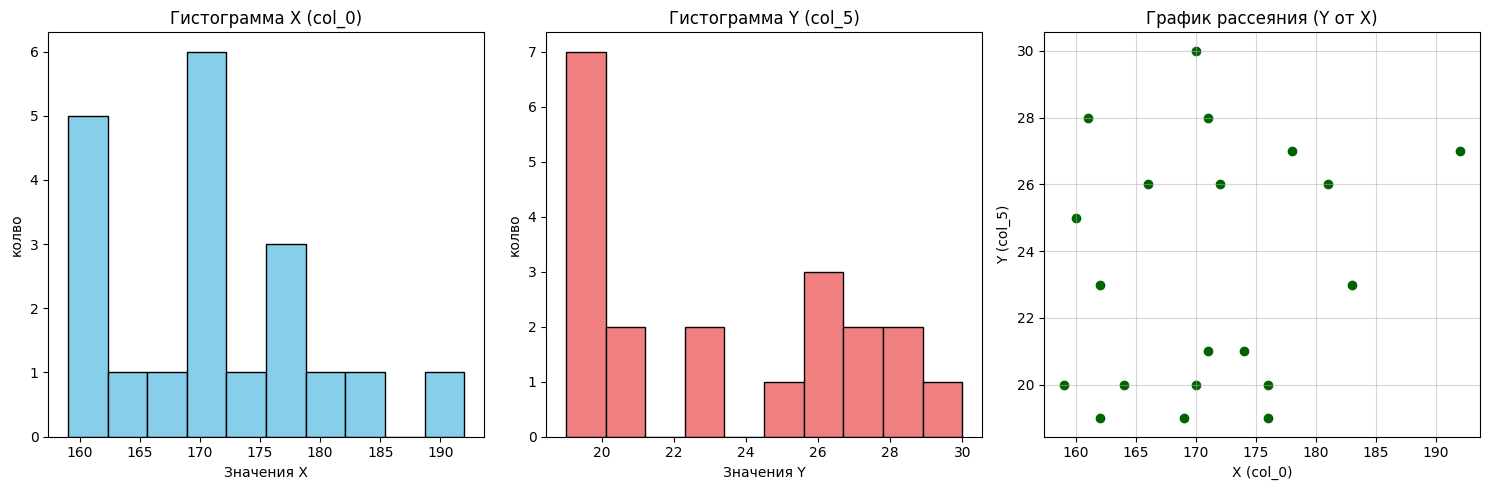

In [170]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(X, bins=None, color='skyblue', edgecolor='black')
plt.title('Гистограмма X (col_0)')
plt.xlabel('Значения X')
plt.ylabel('колво')

plt.subplot(1, 3, 2)
plt.hist(Y, bins=None, color='lightcoral', edgecolor='black')
plt.title('Гистограмма Y (col_5)')
plt.xlabel('Значения Y')
plt.ylabel('колво')


plt.subplot(1, 3, 3)
plt.scatter(X, Y, color='darkgreen', label='Исходные данные')
plt.title('График рассеяния (Y от X)')
plt.xlabel('X (col_0)')
plt.ylabel('Y (col_5)')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# Регрессии


In [171]:
SST = np.sum((Y - mean_Y)**2)
results = {}

def ols_solve(X_matrix, Y_vector):
    XT = X_matrix.T
    XTX = XT @ X_matrix
    XTX_inv = np.linalg.inv(XTX)
    XT_Y = XT @ Y_vector
    w = XTX_inv @ XT_Y
    return w

# Линейная регрессия
X_linear = np.vstack([np.ones(n), X]).T
w_linear = ols_solve(X_linear, Y)
y_pred_linear = X_linear @ w_linear
SSE_linear = np.sum((Y - y_pred_linear)**2)
R2_linear = 1 - SSE_linear / SST
results['linear'] = {'w': w_linear, 'R2': R2_linear, 'SSE': SSE_linear}
print(f"Линейная: y = {w_linear[1]:.4f}*x + {w_linear[0]:.4f} | R2: {R2_linear:.4f}")

# Квадратичная регрессия
X_quadratic = np.vstack([np.ones(n), X, X**2]).T
w_quadratic = ols_solve(X_quadratic, Y)
y_pred_quadratic = X_quadratic @ w_quadratic
SSE_quadratic = np.sum((Y - y_pred_quadratic)**2)
R2_quadratic = 1 - SSE_quadratic / SST
results['quadratic'] = {'w': w_quadratic, 'R2': R2_quadratic, 'SSE': SSE_quadratic}
print(f"Квадратичная: y = {w_quadratic[2]:.4f}*x^2 + {w_quadratic[1]:.4f}*x + {w_quadratic[0]:.4f} | R2: {R2_quadratic:.4f}")

# Гиперболическая регрессия
X_inv = 1 / X
X_hyperbolic = np.vstack([np.ones(n), X_inv]).T
w_hyperbolic = ols_solve(X_hyperbolic, Y)
y_pred_hyperbolic = X_hyperbolic @ w_hyperbolic
SSE_hyperbolic = np.sum((Y - y_pred_hyperbolic)**2)
R2_hyperbolic = 1 - SSE_hyperbolic / SST
results['hyperbolic'] = {'w': w_hyperbolic, 'R2': R2_hyperbolic, 'SSE': SSE_hyperbolic}
print(f"Гиперболическая: y = {w_hyperbolic[1]:.4f}/x + {w_hyperbolic[0]:.4f} | R2: {R2_hyperbolic:.4f}")

# Показательная регрессия
Y_ln = np.log(Y)
X_exp = np.vstack([np.ones(n), X]).T
w_ln = ols_solve(X_exp, Y_ln)

w0_exp = np.exp(w_ln[0])
w1_exp = np.exp(w_ln[1])
w_exponential = np.array([w0_exp, w1_exp])

y_pred_exponential = w0_exp * (w1_exp ** X)
SSE_exponential = np.sum((Y - y_pred_exponential)**2)
R2_exponential = 1 - SSE_exponential / SST
results['exponential'] = {'w': w_exponential, 'R2': R2_exponential, 'SSE': SSE_exponential}
print(f"Показательная: y = {w_exponential[0]:.4f} * {w_exponential[1]:.4f}^x | R2: {R2_exponential:.4f}")

Линейная: y = 0.0823*x + 9.3470 | R2: 0.0378
Квадратичная: y = 0.0053*x^2 + -1.7715*x + 169.6891 | R2: 0.0559
Гиперболическая: y = -2351.7113/x + 37.1970 | R2: 0.0347
Показательная: y = 12.4755 * 1.0036^x | R2: 0.0336


# VIs


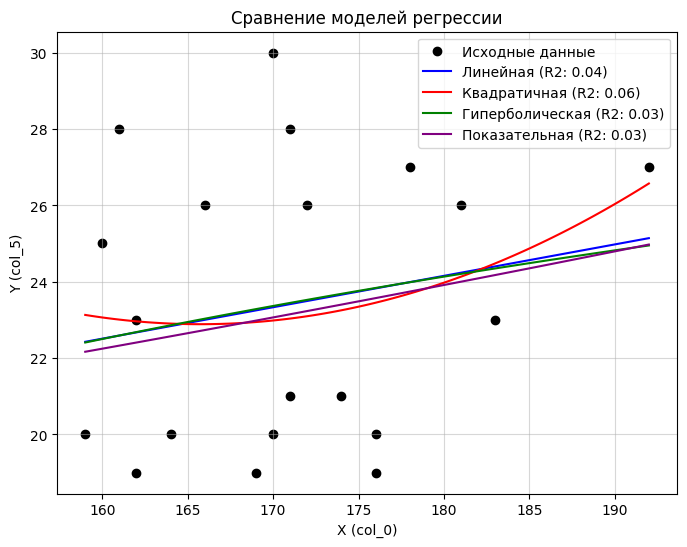

In [172]:
X_plot = np.linspace(X.min(), X.max(), 100)

y_plot_linear = results['linear']['w'][1] * X_plot + results['linear']['w'][0]

w_q = results['quadratic']['w']
y_plot_quadratic = w_q[2] * X_plot**2 + w_q[1] * X_plot + w_q[0]

y_plot_hyperbolic = results['hyperbolic']['w'][1] / X_plot + results['hyperbolic']['w'][0]

w_e = results['exponential']['w']
y_plot_exponential = w_e[0] * (w_e[1] ** X_plot)

plt.figure(figsize=(8, 6))
plt.scatter(X, Y, color='black', label='Исходные данные')
plt.plot(X_plot, y_plot_linear, color='blue', label=f'Линейная (R2: {R2_linear:.2f})')
plt.plot(X_plot, y_plot_quadratic, color='red', label=f'Квадратичная (R2: {R2_quadratic:.2f})')
plt.plot(X_plot, y_plot_hyperbolic, color='green', label=f'Гиперболическая (R2: {R2_hyperbolic:.2f})')
plt.plot(X_plot, y_plot_exponential, color='purple', label=f'Показательная (R2: {R2_exponential:.2f})')

plt.title('Сравнение моделей регрессии')
plt.xlabel('X (col_0)')
plt.ylabel('Y (col_5)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

In [173]:
model_best = 'quadratic'
SSE_best = results[model_best]['SSE']
p_best = 1
df_reg_best = p_best
df_res_best = n - p_best - 1
SSR_best = SST - SSE_best

MSR_best = SSR_best / df_reg_best
MSE_best = SSE_best / df_res_best
F_stat_best = MSR_best / MSE_best
F_crit_best = f.ppf(0.95, df_reg_best, df_res_best)
print(f"SSR={SSR_best:.2f}, SSE={SSE_best:.2f}")
print(f"F-статистика: {F_stat_best:.4f}")
print(f"Критическое F: {F_crit_best:.4f}")


model_worst = 'hyperbolic'
SSE_worst = results[model_worst]['SSE']
p_worst = 1
df_reg_worst = p_worst
df_res_worst = n - p_worst - 1
SSR_worst = SST - SSE_worst
MSR_worst = SSR_worst / df_reg_worst
MSE_worst = SSE_worst / df_res_worst
F_stat_worst = MSR_worst / MSE_worst
F_crit_worst = f.ppf(0.95, df_reg_worst, df_res_worst)

print(f"\n--- Критерий Фишера для Гиперболической регрессии (Worst) ---")
print(f"SSR={SSR_worst:.2f}, SSE={SSE_worst:.2f}")
print(f"F-статистика: {F_stat_worst:.4f}")

SSR=14.02, SSE=236.78
F-статистика: 1.0657
Критическое F: 4.4139

--- Критерий Фишера для Гиперболической регрессии (Worst) ---
SSR=8.70, SSE=242.10
F-статистика: 0.6467


Присутсвует статистически незначимая положительная связь между ростом и возрастом в выборке 
Коэффициенты корреляции близки к нулю
Построенные регрессионные модели имеют крайне низкую объясняющую способность и не являются статистически значимыми согласно F-критерию Фишера. 